<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Meta/blob/main/Demo_MultiCrypto_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DRL Crypto Trading and an Ensemble Implementation

## Installation and Import Packages

In [1]:
%%capture
%cd /
!git clone https://github.com/FredHJC/CryptoTradingDRL
%cd /CryptoTradingDRL/
!pip install git+https://github.com/FredHJC/ElegantRL.git
!pip install git+https://github.com/FredHJC/FinRL.git
!pip install git+https://github.com/FredHJC/FinRL-Meta.git
!pip install yfinance stockstats
!pip install alpaca_trade_api
!pip install ray[default]
!pip install lz4
!pip install ray[tune]
!pip install tensorboardX
!pip install gputil
!pip install trading_calendars
!pip install wrds
!pip install rqdatac
!pip install sqlalchemy==1.2.19

#install talib
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz 
!tar xvzf ta-lib-0.4.0-src.tar.gz
import os
os.chdir('ta-lib') 
!./configure --prefix=/usr
!make
!make install
os.chdir('../')
!pip install TA-Lib

In [2]:
%cd /CryptoTradingDRL/

/CryptoTradingDRL


In [3]:
# from FinRL-Meta.drl_agents.elegantrl_models import DRLAgent as DRLAgent_erl
from drl_agent.elegantrl_models_ensemble import DRLEnsembleAgent as DRLEnsembleAgent_erl
from data_processor.processor_binance import BinanceProcessor as Binance
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

## Functions for Training and Testing

In [4]:
class DataProcessor():
  # Code developed based on opensource library:
  # https://github.com/AI4Finance-Foundation/FinRL-Meta/blob/master/finrl_meta/data_processor.py
  # Date: 12/16/2021

    def __init__(self, data_source):
        self.data_source = data_source
        if self.data_source =='binance':
            try:
                self.processor = Binance(data_source)
                print('Binance successfully connected')
            except:
                raise ValueError('Please input correct account info for binance!')
        else:
            raise ValueError('Data source input is NOT correct.')
    
    def download_data(self, ticker_list, start_date, end_date, 
                      time_interval) -> pd.DataFrame:
        df = self.processor.download_data(ticker_list = ticker_list, 
                                          start_date = start_date, 
                                          end_date = end_date,
                                          time_interval = time_interval)
        return df
    
    def clean_data(self, df) -> pd.DataFrame:
        df = self.processor.clean_data(df)
        
        return df
    
    def add_technical_indicator(self, df, tech_indicator_list) -> pd.DataFrame:
        self.tech_indicator_list = tech_indicator_list
        df = self.processor.add_technical_indicator(df, tech_indicator_list)

        return df
    
    def df_to_array(self, df, if_vix) -> np.array:
        price_array, tech_array, turbulence_array = self.processor.df_to_array(df,
                                                    self.tech_indicator_list,
                                                    if_vix)
        # data cleaning, fill NaN with 0
        tech_nan_positions = np.isnan(tech_array)
        tech_array[tech_nan_positions] = 0
        
        return price_array, tech_array, turbulence_array
    
    def run(self, ticker_list, start_date, end_date, time_interval, 
            technical_indicator_list, if_vix, cache=False):
        
        cache_csv = '_'.join(ticker_list + [self.data_source, start_date, end_date, time_interval]) + '.csv'
        cache_dir = './cache'
        cache_path = os.path.join(cache_dir, cache_csv)

        if cache and os.path.isfile(cache_path):
            print('Using cached file {}'.format(cache_path))
            self.tech_indicator_list = technical_indicator_list
            data = pd.read_csv(cache_path)
        
        else:
            data = self.download_data(ticker_list, start_date, end_date, time_interval)
            data = self.clean_data(data)
            if cache:
                if not os.path.exists(cache_dir):
                    os.mkdir(cache_dir)
                data.to_csv(cache_path)
        data = self.add_technical_indicator(data, technical_indicator_list)
        if if_vix:
            data = self.add_vix(data)

        price_array, tech_array, turbulence_array = self.df_to_array(data, if_vix)
        tech_nan_positions = np.isnan(tech_array)
        tech_array[tech_nan_positions] = 0

        return price_array, tech_array, turbulence_array



In [5]:
def get_data(start_date, end_date, ticker_list, data_source, time_interval, technical_indicator_list, if_vix = False):
    #process data using data processor
    DP = DataProcessor(data_source)
    price_array, tech_array, turbulence_array = DP.run(ticker_list, start_date
                                                       , end_date, time_interval, 
                                                       technical_indicator_list, 
                                                       if_vix)
    return price_array, tech_array, turbulence_array

In [6]:
def train(price_array, tech_array, turbulence_array,
          env, model_name, if_vix = False,
          **kwargs):
    
    data_config = {'price_array':price_array,
                   'tech_array':tech_array,
                   'turbulence_array':turbulence_array}
    
    #build environment using processed data
    env_instance = env(config=data_config)

    #read parameters and load agents
    current_working_dir = kwargs.get('current_working_dir','./'+str(model_name))

    break_step = kwargs.get('break_step', 1e6)
    erl_params = kwargs.get('erl_params')

    agent = DRLEnsembleAgent_erl(env = env,
                          price_array = price_array,
                          tech_array=tech_array,
                          turbulence_array=turbulence_array)
    
    model = agent.get_model(model_name, model_kwargs = erl_params)
    trained_model = agent.train_model(model=model, 
                                      cwd=current_working_dir,
                                      total_timesteps=break_step)
      
    return current_working_dir

In [7]:
def train_boostrap(start_date,
          end_date,
          ticker_list, 
          data_source,
          time_interval, 
          technical_indicator_list,
          intv=4,
          if_vix=False):
  
    def date_range(start, end, intv):
      from datetime import datetime
      start = datetime.strptime(start,"%Y-%m-%d")
      end = datetime.strptime(end,"%Y-%m-%d")
      diff = (end  - start ) / intv
      for i in range(intv):
          yield (start + diff * i).strftime("%Y-%m-%d")
      yield end.strftime("%Y-%m-%d")

    train_dir_list = list()
    date_list = list(date_range(TRAIN_START_DATE, TRAIN_END_DATE, intv))

    for i in len(intv):
      price_array, tech_array, turbulence_array = get_data(start_date= train_dir_list[i],
            end_date = train_dir_list[i+1],
            ticker_list = TICKER_LIST, 
            data_source = 'binance',
            time_interval= '5m', 
            technical_indicator_list= TECHNICAL_INDICATORS_LIST,
            if_vix=False)
        
      wdr = train(price_array, tech_array, turbulence_array,
              env, model_name, break_step=5e4, if_vix = False, current_working_dir = './'+str(model_name) +'_' + str(i))
      train_dir_list.append(wdr)
    return train_dir_list


In [8]:
def test(start_date, end_date, ticker_list, data_source, time_interval,
            technical_indicator_list, env, model_name, if_vix=False,
            **kwargs):
    #process data using unified data processor
    DP = DataProcessor(data_source)
    price_array, tech_array, turbulence_array = DP.run(ticker_list, start_date
                              , end_date, time_interval, 
                              technical_indicator_list, 
                              if_vix)
    np.save('./price_array.npy', price_array)
    data_config = {'price_array':price_array,
                   'tech_array':tech_array,
                   'turbulence_array':turbulence_array}
    #build environment using processed data
    env_instance = env(config=data_config)

    env_config = {
        "price_array": price_array,
        "tech_array": tech_array,
        "turbulence_array": turbulence_array,
        "if_train": False,
    }
    env_instance = env(config=env_config)

    # load elegantrl needs state dim, action dim and net dim
    net_dimension = kwargs.get("net_dimension", 2 ** 7)
    current_working_dir = kwargs.get("current_working_dir", "./test_" + str(model_name))
    print("price_array: ", len(price_array))
    
    episode_total_assets = DRLEnsembleAgent_erl.DRL_prediction(
        model_name=model_name,
        cwd=current_working_dir,
        net_dimension=net_dimension,
        environment=env_instance,
    )

    return episode_total_assets

In [9]:
def test_ensemble(start_date, end_date, ticker_list, data_source, time_interval,
            technical_indicator_list, env, model_list, if_vix=False, **kwargs):
    #process data using unified data processor
    DP = DataProcessor(data_source)
    price_array, tech_array, turbulence_array = DP.run(ticker_list, start_date
                              , end_date, time_interval, 
                              technical_indicator_list, 
                              if_vix)
    np.save('./price_array.npy', price_array)
    data_config = {'price_array':price_array,
                   'tech_array':tech_array,
                   'turbulence_array':turbulence_array}
    #build environment using processed data
    env_instance = env(config=data_config)

    env_config = {
        "price_array": price_array,
        "tech_array": tech_array,
        "turbulence_array": turbulence_array,
        "if_train": False,
    }
    env_instance = env(config=env_config)

    # load elegantrl needs state dim, action dim and net dim
    net_dimension = kwargs.get("net_dimension", 2 ** 7)
    cwd_list = []
    for model_name in model_list:
      cwd = "./test_" + str(model_name)
      cwd_list.append(cwd)
    print("price_array: ", len(price_array))

    initial_prices = price_array[0,:]
    equal_weight = np.array([1e5/initial_prices[i] for i in range(10)])
    equal_weight_values = []
    for i in range(0, price_array.shape[0]):
      equal_weight_values.append(np.sum(equal_weight * price_array[i]))
    equal_weight_values = np.array(equal_weight_values)
    
    base_returns = list()
    for i in range(price_array.shape[0]-1):
      base_returns.append((equal_weight_values[i+1]-equal_weight_values[i])/equal_weight_values[i])
    print(base_returns[:5])
    episode_total_assets = DRLEnsembleAgent_erl.DRL_prediction_ensemble(
        model_list=model_list,
        cwd_list=cwd_list,
        net_dimension=net_dimension,
        environment=env_instance,
        base_returns=base_returns,
    )

    return episode_total_assets

## Customized Crypto Trading Environment

In [10]:
import numpy as np
import math
import gym

class CryptoEnv:  
  # Customed environment
  # Code developed based on opensource library:
  # https://github.com/AI4Finance-Foundation/FinRL-Meta/blob/master/finrl_meta/env_crypto_trading/env_multiple_crypto.py
  # Date: 12/17/2021

    def __init__(self, config, lookback=1, initial_capital=1e6, 
                 buy_cost_pct=1e-3, sell_cost_pct=1e-3, gamma = 0.99):
        self.lookback = lookback
        self.initial_total_asset = initial_capital
        self.initial_cash = initial_capital
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.max_stock = 1
        self.gamma = gamma
        self.price_array = config['price_array']
        self.tech_array = config['tech_array']
        self._generate_action_normalizer()
        self.crypto_num = self.price_array.shape[1]
        self.max_step = self.price_array.shape[0] - lookback - 1
        
        # reset
        self.time = lookback-1
        self.cash = self.initial_cash
        self.current_price = self.price_array[self.time]
        self.current_tech = self.tech_array[self.time]
        self.stocks = np.zeros(self.crypto_num, dtype=np.float32)

        self.total_asset = self.cash + (self.stocks * self.price_array[self.time]).sum()
        self.episode_return = 0.0  
        self.gamma_return = 0.0
        

        '''env information'''
        self.env_name = 'MulticryptoEnv'
        self.state_dim = 1 + (self.price_array.shape[1] + self.tech_array.shape[1])*lookback
        self.action_dim = self.price_array.shape[1]
        self.if_discrete = False
        self.target_return = 10

        self.observation_space = gym.spaces.Box(
            low=-3000, high=3000, shape=(self.state_dim,), dtype=np.float32
        )
        self.action_space = gym.spaces.Box(
            low=-1, high=1, shape=(self.action_dim,), dtype=np.float32
        )
        self.reward_range = (-np.inf, np.inf)
        self.metadata = {'render.modes': ['human']}


    def reset(self) -> np.ndarray:
        self.time = self.lookback-1
        self.current_price = self.price_array[self.time]
        self.current_tech = self.tech_array[self.time]
        self.cash = self.initial_cash  # reset()
        self.stocks = np.zeros(self.crypto_num, dtype=np.float32)
        self.total_asset = self.cash + (self.stocks * self.price_array[self.time]).sum()
        
        state = self.get_state()
        return state

    def step(self, actions) -> (np.ndarray, float, bool, None):
        self.time += 1
        
        price = self.price_array[self.time]
        for i in range(self.action_dim):
            norm_vector_i = self.action_norm_vector[i]
            actions[i] = actions[i] * norm_vector_i
            
        for index in np.where(actions < 0)[0]:  # sell_index:
            if price[index] > 0:  # Sell only if current asset is > 0
                sell_num_shares = min(self.stocks[index], -actions[index])
                self.stocks[index] -= sell_num_shares
                self.cash += price[index] * sell_num_shares * (1 - self.sell_cost_pct)
                
        for index in np.where(actions > 0)[0]:  # buy_index:
            if price[index] > 0:  # Buy only if the price is > 0 (no missing data in this particular date)
                buy_num_shares = min(self.cash // price[index], actions[index])
                self.stocks[index] += buy_num_shares
                self.cash -= price[index] * buy_num_shares * (1 + self.buy_cost_pct)

        """update time"""
        done = self.time == self.max_step
        state = self.get_state()
        next_total_asset = self.cash + (self.stocks * self.price_array[self.time]).sum()
        reward = (next_total_asset - self.total_asset) * 2 ** -16  
        self.total_asset = next_total_asset
        self.gamma_return = self.gamma_return * self.gamma + reward 
        self.cumu_return = self.total_asset / self.initial_cash
        if done:
            reward = self.gamma_return
            self.episode_return = self.total_asset / self.initial_cash
        return state, reward, done, None

    def get_state(self):
        state =  np.hstack((self.cash * 2 ** -18, self.stocks * 2 ** -3))
        for i in range(self.lookback):
            tech_i = self.tech_array[self.time-i]
            normalized_tech_i = tech_i * 2 ** -15
            state = np.hstack((state, normalized_tech_i)).astype(np.float32)
        return state
    
    def close(self):
        pass

    def _generate_action_normalizer(self):
        action_norm_vector = []
        price_0 = self.price_array[0]
        for price in price_0:
            x = math.floor(math.log(price, 10)) #the order of magnitude 
            action_norm_vector.append(1/((10)**x)) 
            
        action_norm_vector = np.asarray(action_norm_vector) * 10000
        self.action_norm_vector = np.asarray(action_norm_vector)

## Set Parameters

In [39]:
TICKER_LIST = ['BTCUSDT','ETHUSDT','ADAUSDT','BNBUSDT','XRPUSDT','SOLUSDT','DOTUSDT',
         'DOGEUSDT','AVAXUSDT','UNIUSDT']
env = CryptoEnv
TRAIN_START_DATE = '2021-09-01'
TRAIN_END_DATE = '2021-09-20'

TEST_START_DATE = '2021-09-21'
TEST_END_DATE = '2021-09-28'
TECHNICAL_INDICATORS_LIST = ['macd','rsi','cci','dx']

ERL_PARAMS = {"learning_rate": 2 ** -10,"batch_size": 2**11,"gamma":  0.99,
              "seed":312,"net_dimension": 2**9, "target_step": 5000, 
              "eval_time_gap": 30}

## Training

In [40]:
price_array, tech_array, turbulence_array = get_data(start_date= TRAIN_START_DATE,
                                                     end_date = TRAIN_END_DATE,
                                                     ticker_list = TICKER_LIST, 
                                                     data_source = 'binance',
                                                     time_interval= '5m', 
                                                     technical_indicator_list= TECHNICAL_INDICATORS_LIST,
                                                     if_vix=False)

Binance successfully connected
Use default: MACD, RSI, CCI, DX.


In [41]:
price_array.shape

(4324, 10)

In [42]:
train(price_array, 
      tech_array, 
      turbulence_array,
      env=env, 
      model_name='ddpg', 
      current_working_dir='./test_ddpg',
      erl_params=ERL_PARAMS,
      break_step=5e4,
      if_vix=False
      )

| Remove cwd: ./test_ddpg
| build_env(): Warning. NOT suggest to use `deepcopy(env)`. env_name: MulticryptoEnv
| build_env(): Warning. NOT suggest to use `deepcopy(env)`. env_name: MulticryptoEnv
################################################################################
ID     Step    maxR |    avgR   stdR   avgS  stdS |    expR   objC   etc.
0  1.00e+04    1.13 |
0  1.00e+04    1.13 |    1.13    0.0   4321     0 | 6269.75 879.541430.43
0  1.50e+04    1.13 |    1.13    0.0   4321     0 | 4694.05 512.60-330.26
0  5.00e+04    1.14 |
0  5.00e+04    1.14 |    1.14    0.0   4321     0 | 6386.45   2.22 -49.83
0  5.50e+04    1.14 |    1.14    0.0   4321     0 | 3951.76   0.71 -58.75
| UsedTime:     116 | SavedDir: ./test_ddpg
| ReplayBuffer save in: ./test_ddpg/buffer_0.npz


'./test_ddpg'

In [43]:
train(price_array, 
      tech_array, 
      turbulence_array,
      env=env, 
      model_name='ppo', 
      current_working_dir='./test_ppo',
      erl_params=ERL_PARAMS,
      break_step=5e4,
      if_vix=False
      )

| Remove cwd: ./test_ppo
| build_env(): Warning. NOT suggest to use `deepcopy(env)`. env_name: MulticryptoEnv
| build_env(): Warning. NOT suggest to use `deepcopy(env)`. env_name: MulticryptoEnv
################################################################################
ID     Step    maxR |    avgR   stdR   avgS  stdS |    expR   objC   etc.
0  4.32e+03    1.16 |
0  4.32e+03    1.16 |    1.16    0.0   4321     0 |   -0.00  10.37   0.31  -0.50
0  8.64e+03    1.16 |    1.16    0.0   4321     0 |   -0.00  16.24   0.29  -0.50
0  4.76e+04    1.21 |
0  4.76e+04    1.21 |    1.21    0.0   4321     0 |    0.00   0.28   0.34  -0.50
0  5.19e+04    1.37 |
0  5.19e+04    1.37 |    1.37    0.0   4321     0 |    0.00   0.23   0.30  -0.50
| UsedTime:     135 | SavedDir: ./test_ppo


'./test_ppo'

In [44]:
train(price_array, 
      tech_array, 
      turbulence_array,
      env=env, 
      model_name='td3', 
      current_working_dir='./test_td3',
      erl_params=ERL_PARAMS,
      break_step=5e4,
      if_vix=False
      )

| Remove cwd: ./test_td3
| build_env(): Warning. NOT suggest to use `deepcopy(env)`. env_name: MulticryptoEnv
| build_env(): Warning. NOT suggest to use `deepcopy(env)`. env_name: MulticryptoEnv
################################################################################
ID     Step    maxR |    avgR   stdR   avgS  stdS |    expR   objC   etc.
0  1.00e+04    0.93 |
0  1.00e+04    0.93 |    0.93    0.0   4321     0 | 9318.00 546.00  -5.71
0  1.50e+04    0.96 |
0  1.50e+04    0.96 |    0.96    0.0   4321     0 |-8009.71  59.44  -1.71
0  2.00e+04    0.99 |
0  2.00e+04    0.99 |    0.99    0.0   4321     0 |-7930.14  27.52  -4.53
0  2.50e+04    0.99 |    0.99    0.0   4321     0 |-7920.51  10.83  -6.86
| UsedTime:     136 | SavedDir: ./test_td3
| ReplayBuffer save in: ./test_td3/buffer_0.npz


'./test_td3'

In [45]:
train(price_array, 
      tech_array, 
      turbulence_array,
      env=env, 
      model_name='a2c', 
      current_working_dir='./test_a2c',
      erl_params=ERL_PARAMS,
      break_step=5e4,
      if_vix=False
      )

| Remove cwd: ./test_a2c
| build_env(): Warning. NOT suggest to use `deepcopy(env)`. env_name: MulticryptoEnv
| build_env(): Warning. NOT suggest to use `deepcopy(env)`. env_name: MulticryptoEnv
################################################################################
ID     Step    maxR |    avgR   stdR   avgS  stdS |    expR   objC   etc.
0  4.32e+03    1.07 |
0  4.32e+03    1.07 |    1.07    0.0   4321     0 |   -0.00  10.37   0.00  -0.50
0  8.64e+03    1.11 |
0  8.64e+03    1.11 |    1.11    0.0   4321     0 |   -0.00   5.39   0.00  -0.50
0  1.30e+04    1.11 |    1.10    0.0   4321     0 |    0.00   0.95   0.00  -0.50
0  5.19e+04    1.12 |
0  5.19e+04    1.12 |    1.12    0.0   4321     0 |    0.00   0.64   0.00  -0.51
| UsedTime:     137 | SavedDir: ./test_a2c


'./test_a2c'

In [46]:
# train_dir_list = train_boostrap(price_array, tech_array, turbulence_array, env=env, model_name='ddpg',  intv = 4)

## Testing

In [47]:
model_list = ['ppo', 'ddpg', 'a2c', 'td3']

In [48]:
accounts = list()
for model_name in model_list:
  print(model_name)
  account_result = test(start_date = TEST_START_DATE, 
                          end_date = TEST_END_DATE,
                          ticker_list = TICKER_LIST, 
                          data_source = 'binance',
                          time_interval= '5m', 
                          technical_indicator_list= TECHNICAL_INDICATORS_LIST,
                          drl_lib='elegantrl', 
                          env=env, 
                          model_name=model_name, 
                          net_dimension = 2**9)
  print("===================================="+"\n")
  accounts.append(account_result)

ppo
Binance successfully connected
Use default: MACD, RSI, CCI, DX.
price_array:  1729
Test Finished!
episode_return 1.124081084006292

ddpg
Binance successfully connected
Use default: MACD, RSI, CCI, DX.
price_array:  1729
Test Finished!
episode_return 1.0756728471030004

a2c
Binance successfully connected
Use default: MACD, RSI, CCI, DX.
price_array:  1729
Test Finished!
episode_return 1.0592278298108

td3
Binance successfully connected
Use default: MACD, RSI, CCI, DX.
price_array:  1729
Test Finished!
episode_return 1.0378769831574002



In [49]:
ensemble_result = test_ensemble(start_date = TEST_START_DATE, 
                        end_date = TEST_END_DATE,
                        ticker_list = TICKER_LIST, 
                        data_source = 'binance',
                        time_interval= '5m', 
                        technical_indicator_list= TECHNICAL_INDICATORS_LIST,
                        env=env, 
                        model_list=model_list, 
                        net_dimension = 2**9)

Binance successfully connected
Use default: MACD, RSI, CCI, DX.
price_array:  1729
[-0.013000926045019413, -0.010713308430596792, -0.014477272600204209, -0.003704779124049229, 0.013506859194069337]
Test Finished!
episode_return 1.124081084006292
Test Finished!
episode_return 1.0756728471030004
Test Finished!
episode_return 1.0592278298108
Test Finished!
episode_return 1.0378769831574002


## Plotting

In [50]:
# ['ppo', 'ddpg', 'a2c', 'td3']
ppo_result = accounts[0]
ddpg_result = accounts[1]
td3_result  = accounts[3]

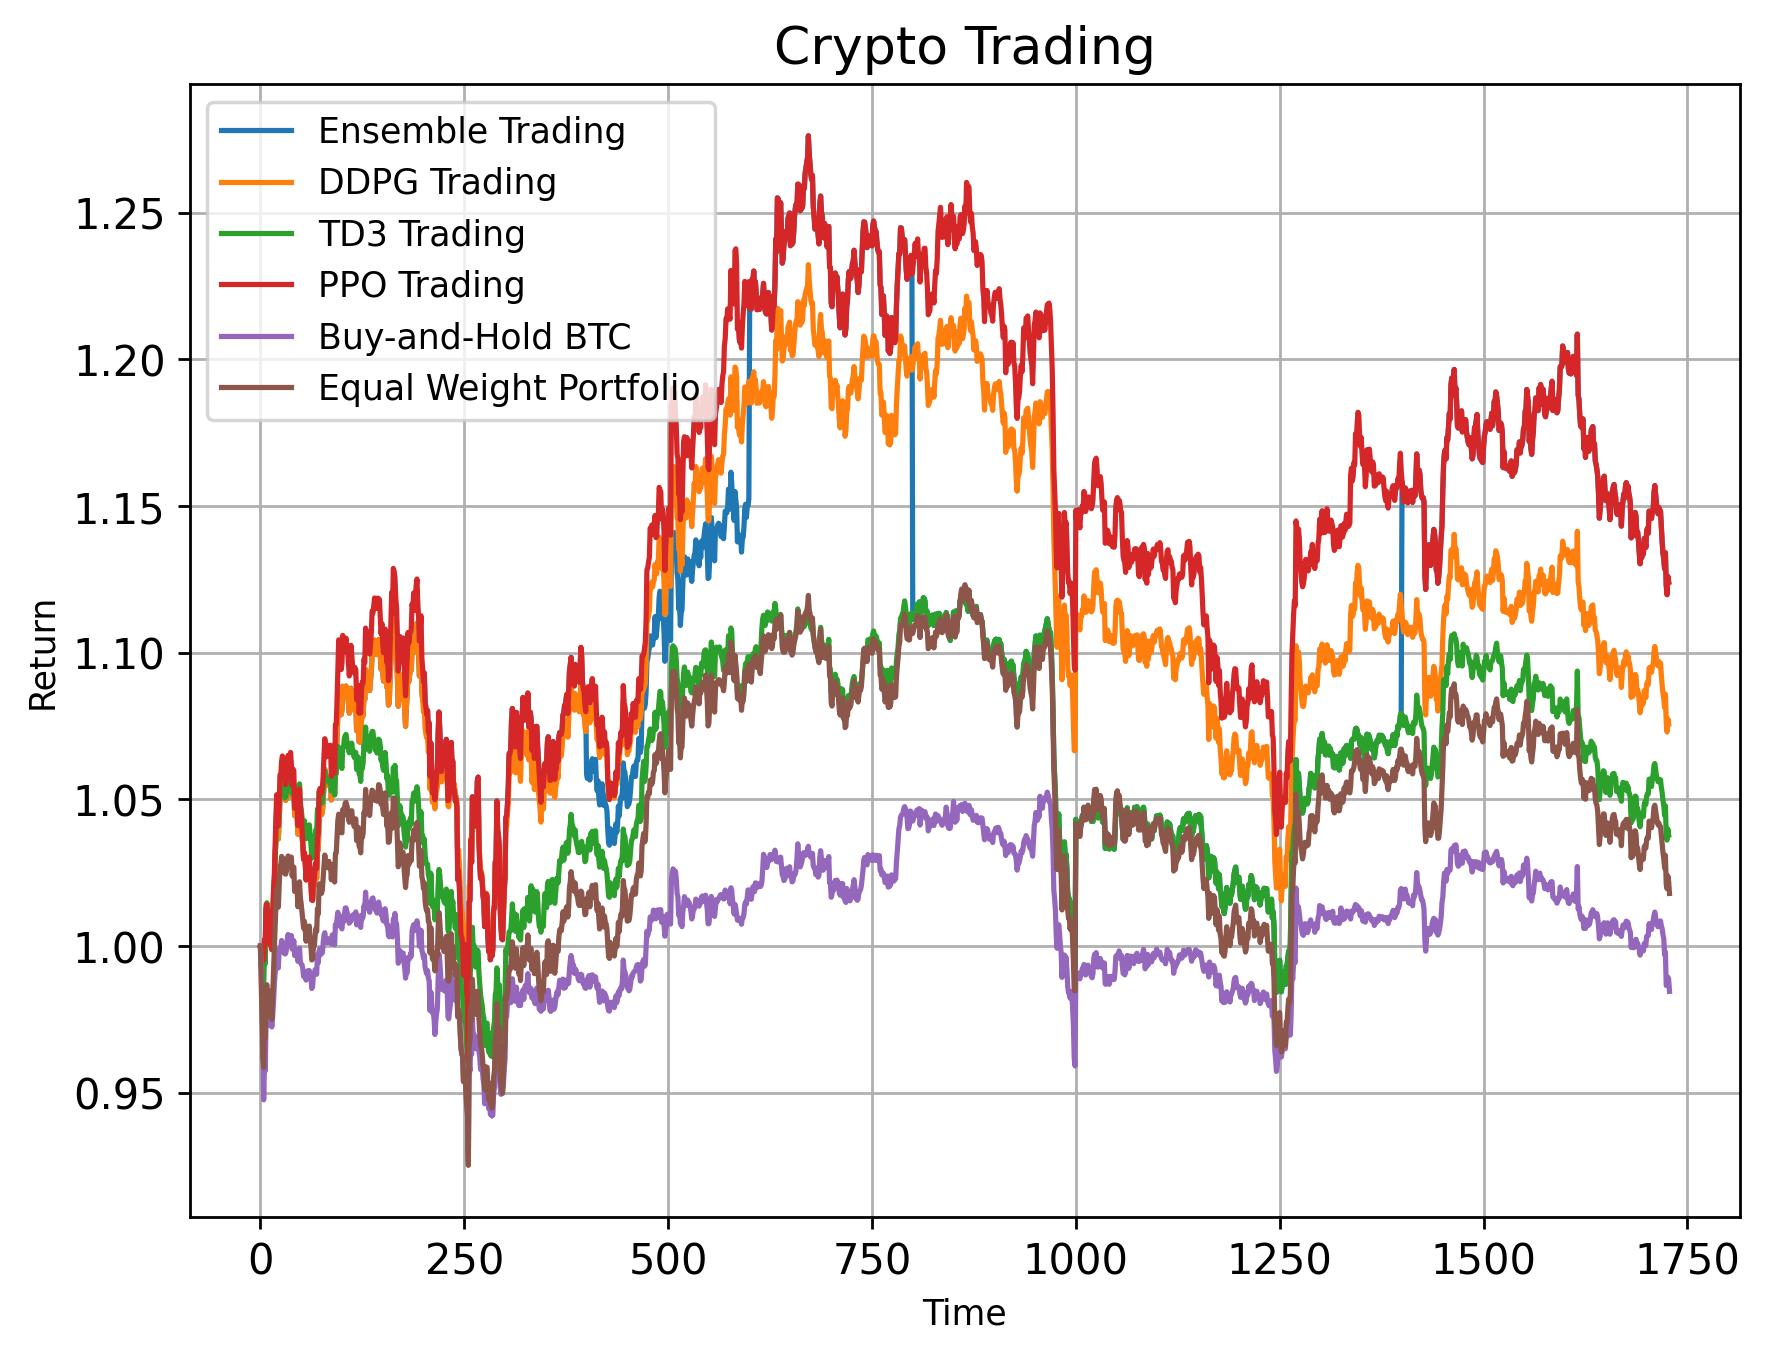

In [51]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline
#calculate ensemble returns
ensemble_test = np.array(ensemble_result)
ensemble_returns = ensemble_test/ensemble_test[0]
#calculate ppo returns
ppo_test = np.array(ppo_result)
ppo_returns = ppo_test/ppo_test[0]
#calculate ddpg returns
ddpg_test = np.array(ddpg_result)
ddpg_returns = ddpg_test/ddpg_test[0]
#calculate td3 returns
td3_test = np.array(td3_result)
td3_returns = td3_test/td3_test[0]
#calculate buy-and-hold btc returns
price_array = np.load('./price_array.npy')
btc_prices = price_array[:,0]
buy_hold_btc_returns = btc_prices/btc_prices[0]
#calculate equal weight portfolio returns
price_array = np.load('./price_array.npy')
initial_prices = price_array[0,:]
equal_weight = np.array([1e5/initial_prices[i] for i in range(10)])
equal_weight_values = []
for i in range(0, price_array.shape[0]):
  equal_weight_values.append(np.sum(equal_weight * price_array[i]))
equal_weight_values = np.array(equal_weight_values)
equal_returns = equal_weight_values/equal_weight_values[0]
#plot 
plt.figure(figsize=(8, 6), dpi=250)
plt.grid()
plt.grid(which='minor', axis='y')
plt.title('Crypto Trading', fontsize=15)
plt.plot(ensemble_returns, label = 'Ensemble Trading')
plt.plot(ddpg_returns, label = 'DDPG Trading')
plt.plot(td3_returns, label = 'TD3 Trading')
plt.plot(ppo_returns, label = 'PPO Trading')
plt.plot(buy_hold_btc_returns, label = 'Buy-and-Hold BTC')
plt.plot(equal_returns, label = 'Equal Weight Portfolio')
plt.ylabel('Return', fontsize=10)
plt.xlabel('Time', fontsize=10)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.legend()

In [52]:
def asset_to_return(arr):
    returns = list()
    n = len(arr)
    for i in range(1, n):
        returns.append((arr[i] - arr[i - 1]) / arr[i - 1])
    return returns

def sharpe_ratio(agent_returns, base_returns):
    agent_returns = np.array(agent_returns).flatten()
    step = len(agent_returns)
    base_returns = np.array(base_returns)[:step].flatten()
    excess_returns = agent_returns - base_returns
    avg_excess_return = np.mean(excess_returns, axis=0)
    sharpe_ratio = avg_excess_return / np.std(agent_returns)

    return sharpe_ratio

In [1]:
# for model_name, assest_result in zip(model_list, accounts):
#   print(model_name)
#   print(sharpe_ratio(asset_to_return(assest_result), asset_to_return(equal_weight_values[:-1])))